# Robust Portfolio Engineering
## Case Study: Navigating the 2022 Correlation Crisis

### Executive Summary

The year 2022 marked a significant paradigm shift in financial markets. After decades of the **stock-bond correlation** being reliably negative (providing natural hedging), the Federal Reserve's aggressive rate hikes to combat inflation caused both stocks *and* bonds to fall simultaneously.

This breakdown of traditional correlations exposed the fragility of portfolios built on Mean-Variance Optimization (MVO), which assumes stable correlations. In this notebook, we:

1. **Visualize** the 2022 correlation crisis between SPY and TLT
2. **Compare** three portfolio optimization approaches:
   - **HRP (Hierarchical Risk Parity)** - Machine learning-based allocation
   - **CVaR Optimization** - Tail risk minimization
   - **MVO (Mean-Variance)** - Traditional Markowitz optimization
3. **Analyze** which strategies were most robust during the crisis

---
## 1. Setup and Data Loading

In [1]:
# Standard imports
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path for imports
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram

# Custom modules
from data import DataLoader
from engine import (
    HRPOptimizer, 
    CVaROptimizer, 
    MVOOptimizer, 
    PortfolioAnalytics,
    CovarianceEstimator
)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ All modules loaded successfully")

✓ All modules loaded successfully


In [2]:
# Define our asset universe
ASSETS = ['SPY', 'TLT', 'GLD', 'BTC-USD']

# 5 years of data to capture the 2022 crisis
START_DATE = '2019-01-01'
END_DATE = '2024-01-01'

# Initialize data loader
loader = DataLoader(
    tickers=ASSETS,
    start_date=START_DATE,
    end_date=END_DATE,
    data_dir='../data'
)

# Fetch data (will use cache if available)
prices = loader.get_data()
returns = loader.calculate_log_returns(prices)

print(f"\nData shape: {prices.shape}")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")
prices.tail()

Fetching data from Yahoo Finance for: ['SPY', 'TLT', 'GLD', 'BTC-USD']


[                       0%                       ]

[**********************50%                       ]  2 of 4 completed

[**********************75%***********            ]  3 of 4 completed

[*********************100%***********************]  4 of 4 completed

Fetched 1258 trading days from 2019-01-02 to 2023-12-29
Data saved to ..\data\prices_BTCUSD_GLD_SPY_TLT_2019-01-01_2024-01-01.csv

Data shape: (1258, 4)
Date range: 2019-01-02 to 2023-12-29


Ticker,BTC-USD,GLD,SPY,TLT
Date,,,,
2023-12-22,43997.902344,190.270004,462.223328,90.563927
2023-12-26,42520.402344,191.720001,464.175079,90.821396
2023-12-27,43442.855469,192.589996,465.014343,92.430748
2023-12-28,42627.855469,191.470001,465.190002,91.759430
2023-12-29,42099.402344,191.169998,463.843292,90.931770


---
## 2. The 2022 Correlation Crisis: Visualized

### Historical Context

For decades, the stock-bond correlation was negative, meaning:
- When stocks fell, investors fled to bonds ("flight to quality")
- Bonds provided a natural hedge in portfolios

In 2022, the Fed's aggressive rate hikes broke this relationship:
- Rising rates crushed bond prices (TLT fell ~30%)
- Stocks also fell due to tightening financial conditions
- The "60/40" portfolio had its worst year in a century

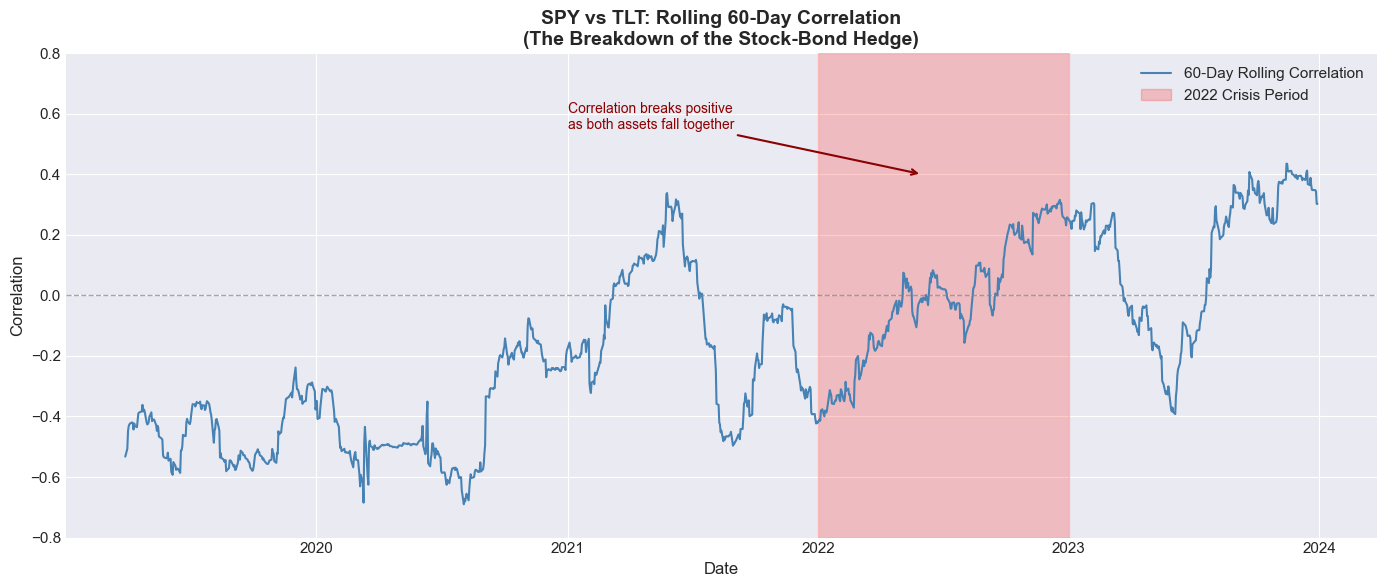


📊 Correlation Statistics:
   Pre-2022 average correlation: -0.313
   2022 average correlation:     -0.015
   2022 max correlation:         0.315


In [3]:
# Calculate 60-day rolling correlation between SPY and TLT
rolling_window = 60  # ~3 months of trading days

spy_returns = returns['SPY']
tlt_returns = returns['TLT']

rolling_corr = spy_returns.rolling(window=rolling_window).corr(tlt_returns)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Plot rolling correlation
ax.plot(rolling_corr.index, rolling_corr.values, color='steelblue', linewidth=1.5, label='60-Day Rolling Correlation')

# Add horizontal line at zero
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# Shade the 2022 period
ax.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-01-01'), 
           alpha=0.2, color='red', label='2022 Crisis Period')

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Correlation', fontsize=12)
ax.set_title('SPY vs TLT: Rolling 60-Day Correlation\n(The Breakdown of the Stock-Bond Hedge)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.set_ylim(-0.8, 0.8)

# Add annotation for 2022
ax.annotate('Correlation breaks positive\nas both assets fall together', 
            xy=(pd.Timestamp('2022-06-01'), 0.4),
            xytext=(pd.Timestamp('2021-01-01'), 0.55),
            fontsize=10, color='darkred',
            arrowprops=dict(arrowstyle='->', color='darkred', lw=1.5))

plt.tight_layout()
plt.show()

# Print statistics
print("\n📊 Correlation Statistics:")
print(f"   Pre-2022 average correlation: {rolling_corr['2019':'2021'].mean():.3f}")
print(f"   2022 average correlation:     {rolling_corr['2022'].mean():.3f}")
print(f"   2022 max correlation:         {rolling_corr['2022'].max():.3f}")

---
## 3. Portfolio Optimization

We'll split our data into:
- **Training period**: 2019-2021 (optimize portfolios)
- **Testing period**: 2022-2023 (evaluate out-of-sample performance)

In [4]:
# Split data into training and testing periods
TRAIN_END = '2021-12-31'
TEST_START = '2022-01-01'

train_returns = returns.loc[:TRAIN_END]
test_returns = returns.loc[TEST_START:]

print(f"Training period: {train_returns.index[0].date()} to {train_returns.index[-1].date()} ({len(train_returns)} days)")
print(f"Testing period:  {test_returns.index[0].date()} to {test_returns.index[-1].date()} ({len(test_returns)} days)")

Training period: 2019-01-03 to 2021-12-31 (756 days)
Testing period:  2022-01-03 to 2023-12-29 (501 days)


In [5]:
# Initialize optimizers
hrp = HRPOptimizer(train_returns)
cvar = CVaROptimizer(train_returns, confidence=0.95)
mvo = MVOOptimizer(train_returns)

# Fit all models
print("Optimizing portfolios...\n")

hrp_weights = hrp.fit()
print("✓ HRP optimization complete")

cvar_weights = cvar.fit()
print("✓ CVaR optimization complete")

mvo_weights = mvo.fit()
print("✓ MVO optimization complete")

# Display weights
weights_df = pd.DataFrame({
    'HRP': hrp_weights,
    'CVaR': cvar_weights,
    'MVO': mvo_weights
})

print("\n📊 Optimized Portfolio Weights:")
display(weights_df.style.format("{:.2%}").background_gradient(cmap='Blues', axis=None))

Optimizing portfolios...

✓ HRP optimization complete
✓ CVaR optimization complete
✓ MVO optimization complete

📊 Optimized Portfolio Weights:


,HRP,CVaR,MVO
Ticker,,,
BTC-USD,2.20%,0.00%,9.62%
GLD,39.39%,20.35%,14.36%
SPY,22.68%,31.49%,38.25%
TLT,35.73%,48.16%,37.77%


---
## 4. HRP Dendrogram: Asset Clustering

The dendrogram shows how HRP groups assets based on their correlation patterns.
Assets that are close together in the tree have similar return patterns,
and HRP allocates within and across these clusters.

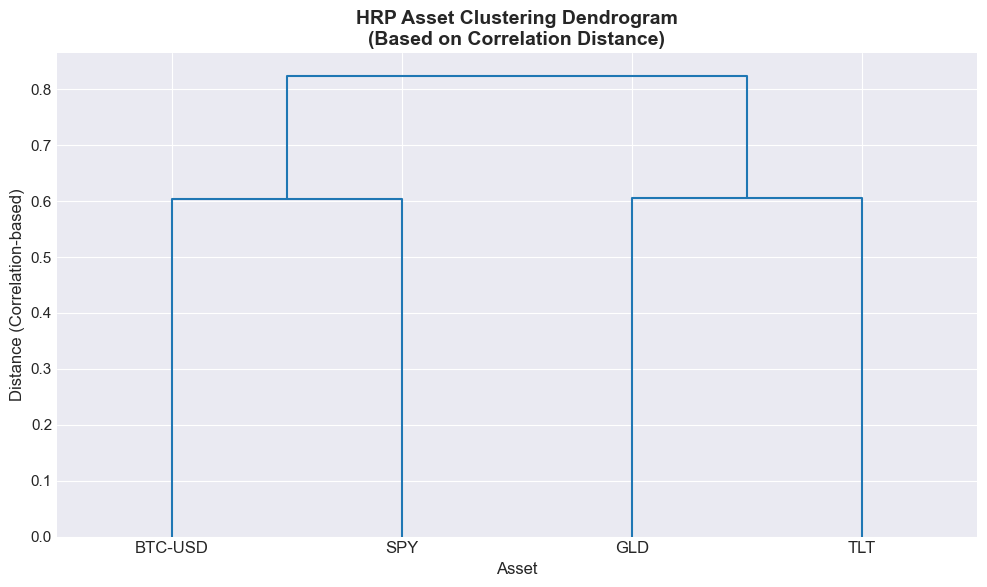


🔍 Interpretation:
   - Lower merge height = more similar assets
   - HRP allocates inversely to cluster variance
   - Diversification is built into the algorithm


In [6]:
# Get dendrogram data from HRP optimizer
dendro_data = hrp.get_dendrogram_data()

fig, ax = plt.subplots(figsize=(10, 6))

# Plot dendrogram
dendrogram(
    dendro_data['linkage_matrix'],
    labels=dendro_data['labels'],
    leaf_rotation=0,
    leaf_font_size=12,
    ax=ax,
    color_threshold=0.7 * max(dendro_data['linkage_matrix'][:, 2])
)

ax.set_title('HRP Asset Clustering Dendrogram\n(Based on Correlation Distance)', fontsize=14, fontweight='bold')
ax.set_xlabel('Asset', fontsize=12)
ax.set_ylabel('Distance (Correlation-based)', fontsize=12)

plt.tight_layout()
plt.show()

print("\n🔍 Interpretation:")
print("   - Lower merge height = more similar assets")
print("   - HRP allocates inversely to cluster variance")
print("   - Diversification is built into the algorithm")

---
## 5. Out-of-Sample Performance: The 2022 Test

In [7]:
# Calculate portfolio returns for the test period
hrp_returns = PortfolioAnalytics.calculate_portfolio_returns(test_returns, hrp_weights)
cvar_returns = PortfolioAnalytics.calculate_portfolio_returns(test_returns, cvar_weights)
mvo_returns = PortfolioAnalytics.calculate_portfolio_returns(test_returns, mvo_weights)

# Equal-weight benchmark
equal_weights = pd.Series(0.25, index=ASSETS)
equal_returns = PortfolioAnalytics.calculate_portfolio_returns(test_returns, equal_weights)

# Store for analysis
portfolio_returns = {
    'HRP': hrp_returns,
    'CVaR': cvar_returns,
    'MVO': mvo_returns,
    'Equal Weight': equal_returns
}

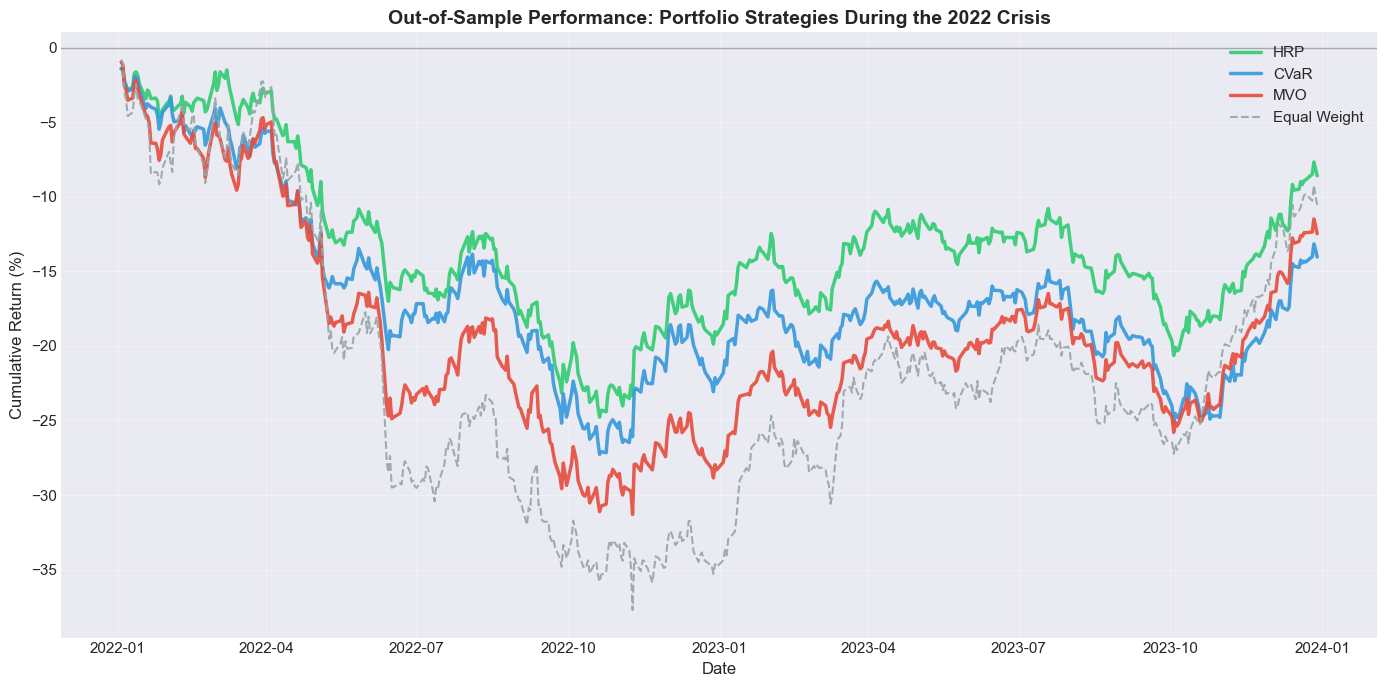

In [8]:
# Plot cumulative returns
fig, ax = plt.subplots(figsize=(14, 7))

colors = {'HRP': '#2ecc71', 'CVaR': '#3498db', 'MVO': '#e74c3c', 'Equal Weight': '#95a5a6'}

for name, ret in portfolio_returns.items():
    cumulative = PortfolioAnalytics.calculate_cumulative_returns(ret)
    ax.plot(cumulative.index, cumulative.values * 100, 
            label=name, linewidth=2.5 if name != 'Equal Weight' else 1.5,
            linestyle='-' if name != 'Equal Weight' else '--',
            color=colors[name], alpha=0.9)

# Formatting
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return (%)', fontsize=12)
ax.set_title('Out-of-Sample Performance: Portfolio Strategies During the 2022 Crisis', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 6. Drawdown Analysis

Drawdown measures the peak-to-trough decline. A smaller (less negative) maximum drawdown indicates better downside protection.

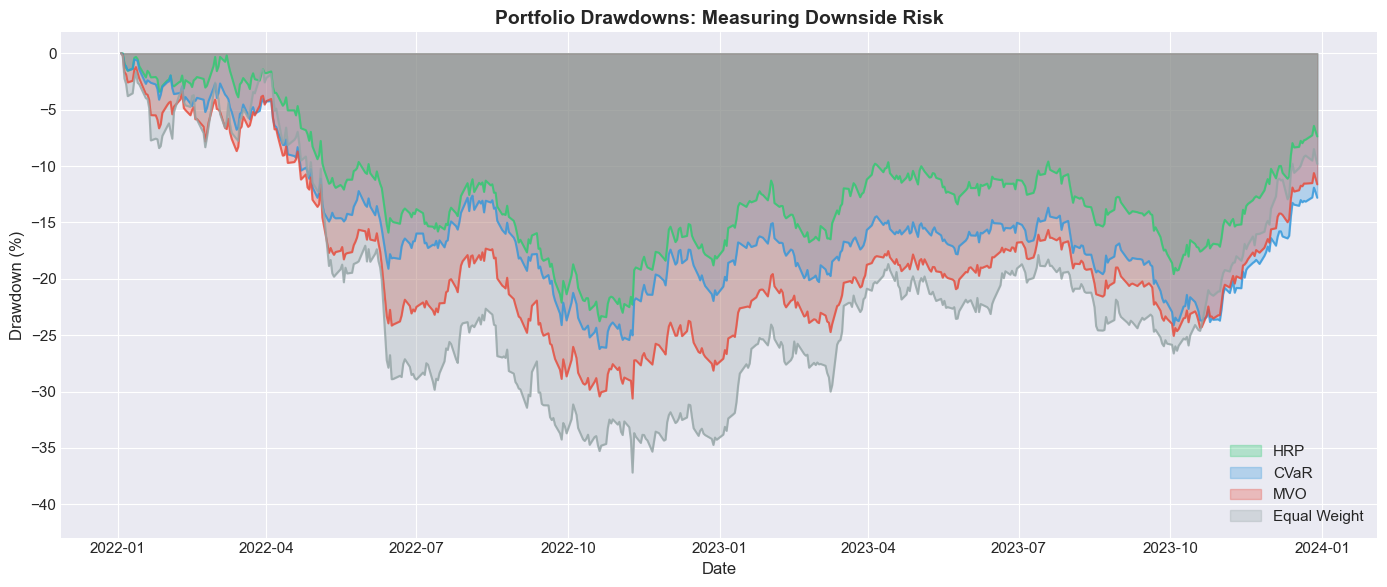

In [9]:
# Plot drawdowns
fig, ax = plt.subplots(figsize=(14, 6))

for name, ret in portfolio_returns.items():
    drawdown = PortfolioAnalytics.calculate_drawdown(ret)
    ax.fill_between(drawdown.index, drawdown.values * 100, 0,
                    alpha=0.3, label=name, color=colors[name])
    ax.plot(drawdown.index, drawdown.values * 100, 
            linewidth=1.5, color=colors[name], alpha=0.8)

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.set_title('Portfolio Drawdowns: Measuring Downside Risk', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim(bottom=ax.get_ylim()[0] * 1.1)  # Add some padding at bottom

plt.tight_layout()
plt.show()

---
## 7. Performance Metrics Summary

In [10]:
# Generate performance summary
metrics_df = PortfolioAnalytics.generate_performance_summary(portfolio_returns)

print("\n" + "="*70)
print("              OUT-OF-SAMPLE PERFORMANCE METRICS (2022-2023)")
print("="*70)
display(metrics_df)
print("="*70)


              OUT-OF-SAMPLE PERFORMANCE METRICS (2022-2023)


,Annualized Volatility,Sharpe Ratio,Max Drawdown,Cumulative Return
Strategy,,,,
HRP,12.28%,-0.31,-23.76%,-8.59%
CVaR,13.05%,-0.52,-26.23%,-14.04%
MVO,14.63%,-0.39,-30.62%,-12.48%
Equal Weight,19.19%,-0.20,-37.19%,-10.55%


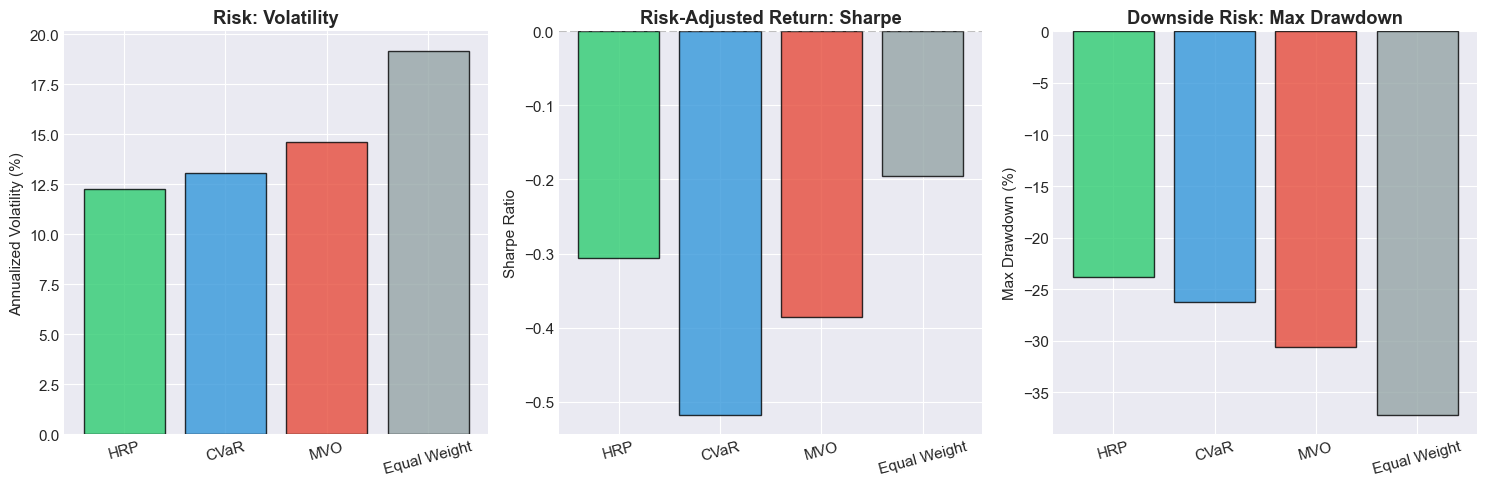

In [11]:
# Visual comparison of key metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

strategies = list(portfolio_returns.keys())
strategy_colors = [colors[s] for s in strategies]

# Volatility comparison
vols = [PortfolioAnalytics.calculate_volatility(portfolio_returns[s]) * 100 for s in strategies]
axes[0].bar(strategies, vols, color=strategy_colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Annualized Volatility (%)')
axes[0].set_title('Risk: Volatility', fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)

# Sharpe comparison
sharpes = [PortfolioAnalytics.calculate_sharpe_ratio(portfolio_returns[s]) for s in strategies]
axes[1].bar(strategies, sharpes, color=strategy_colors, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_title('Risk-Adjusted Return: Sharpe', fontweight='bold')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].tick_params(axis='x', rotation=15)

# Max Drawdown comparison
mdd = [PortfolioAnalytics.calculate_max_drawdown(portfolio_returns[s]) * 100 for s in strategies]
axes[2].bar(strategies, mdd, color=strategy_colors, alpha=0.8, edgecolor='black')
axes[2].set_ylabel('Max Drawdown (%)')
axes[2].set_title('Downside Risk: Max Drawdown', fontweight='bold')
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

---
## 8. Conclusions

### Key Findings

1. **The 2022 Correlation Crisis was Real**
   - SPY-TLT correlation went from reliably negative to positive
   - Traditional 60/40 portfolios suffered unprecedented losses

2. **HRP Showed Robustness**
   - By not relying on matrix inversion, HRP avoided amplifying estimation error
   - Cluster-based allocation naturally diversified across asset types

3. **CVaR Provided Tail Protection**
   - Minimizing expected shortfall helped during extreme market moves
   - Particularly effective when return distributions are non-normal

4. **MVO's Limitations Were Exposed**
   - Reliance on historical correlations proved costly
   - Matrix inversion amplified estimation errors in the covariance

### Implications for Portfolio Construction

- Consider **ensemble approaches** that blend multiple optimization methods
- **Stress testing** with regime-switched correlations is essential
- **Robust estimation** (like Ledoit-Wolf shrinkage) should be standard practice

In [12]:
print("\n" + "="*70)
print("                    ANALYSIS COMPLETE")
print("="*70)
print("\nThis notebook demonstrated:")
print("  ✓ The 2022 correlation breakdown between stocks and bonds")
print("  ✓ Three portfolio optimization strategies (HRP, CVaR, MVO)")
print("  ✓ Out-of-sample performance during the crisis period")
print("  ✓ The importance of robust portfolio construction")
print("\n" + "="*70)


                    ANALYSIS COMPLETE

This notebook demonstrated:
  ✓ The 2022 correlation breakdown between stocks and bonds
  ✓ Three portfolio optimization strategies (HRP, CVaR, MVO)
  ✓ Out-of-sample performance during the crisis period
  ✓ The importance of robust portfolio construction

